# Re-running analysis in Figure 2 using trimmed regions

In [27]:
## Basics
import numpy as np
import pandas as pd
import glob
import mdtraj as md
from sklearn.neighbors import KernelDensity

## Local functions
import sys
sys.path.append("../../code/scripts")
import parseaf as paf
import composition as comp

## Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams.update({'font.size': 14})
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = "Arial"

## Colors
cscheme = {'pos':'#0177BB', 'neg':'#CB3627', 'dis':'#828282', 'helix':'#009988', 'sheet':'#EE7733', 'cr':'#AA4499',
          'null':"black"}

## Set seed for consistency
### In the future when writing code with random remember to use new methods which explicitly create generators
seed = 212121

In [2]:
# Filepaths
#path_to_af_data = "/Volumes/DATA/alphafold/UP000002311_559292_YEAST/"
path_to_af_data = '/Users/rosalindpan/hcrpaper_data/UP000002311_559292_YEAST_v2/'

In [3]:
import warnings
warnings.filterwarnings('ignore')

### Local functions

In [4]:
def get_ss_freqs(seq, counts = False, sort_output = True, gaps = False):
    ss_types = ['C', 'E', 'H']
    
    all_seq_ss = []
    all_seq_freqs = []
    
    # Parse sequence
    seq = list(seq)
    seq_ss, seq_counts = np.unique(seq, return_counts=True)
    zero_freq_ss = np.setxor1d(ss_types, seq_ss)

    seq_ss = np.append(seq_ss, zero_freq_ss)
    seq_freqs = np.append(seq_counts, np.zeros(zero_freq_ss.size))
    if not counts:
        seq_freqs = seq_freqs / len(seq)

    if sort_output:
        seq_freqs_sorted = seq_freqs[seq_ss.argsort()]
        all_seq_freqs.append(seq_freqs_sorted)

    else:
        all_seq_ss.append(seq_ss)
        all_seq_freqs.append(seq_freqs)
    
    if sort_output:
        return(all_seq_freqs)
    else:
        return(all_seq_ss, all_seq_freqs)
    
    
def subcategorybar(X, vals, labs, width=0.8, colors=None):
    n = len(vals)
    _X = np.arange(len(X))
    if colors:
        for i in range(n):
            plt.bar(_X - width/2. + i/float(n)*width, vals[i], 
                    width=width/float(n), align="edge", label=labs[i], color=colors[i])
    else:
        for i in range(n):
            plt.bar(_X - width/2. + i/float(n)*width, vals[i], 
                    width=width/float(n), align="edge", label=labs[i])
    plt.xticks(_X, X)
    plt.legend()

## A

In [6]:
df = pd.read_csv('../../data/charged_regions/cr_trimmed_raw.csv',
                comment="#")

In [7]:
# testing filepaths; this should return an accessible filepath and real file
paf.get_alphafold_fp(df.iloc[4]["uni_id"], path_to_af_data, version='2')

'/Users/rosalindpan/hcrpaper_data/UP000002311_559292_YEAST_v2/AF-P31385-F1-model_v2.pdb'

In [9]:
# Calculate normalized hydropathy, net charge, and percent disordered for each sequence
hits_disordered_frac = []
hits_conf = []
hits_ss = []

for index, row in df.iterrows():
    orf = row['orf']
    uid = row['uni_id']
    seq = row['region.seq']
    
    # Read alphafold pLDDT scoress for the sequence
    af_fp = paf.get_alphafold_fp(df.iloc[4]["uni_id"], path_to_af_data, version='2')+'.gz'
    try:
        pLDDTs = paf.read_bfactor_from_pdb(af_fp)[row['left.bound']:row['right.bound']+1]
    except FileNotFoundError:
        print(af_fp)
        continue
    
    # Get confidence scores mask
    conf = [True if i > 70. else False for i in pLDDTs]
    
    # Secondary structure prediction for each region
    structure = md.load(af_fp)
    ss = md.compute_dssp(structure, simplified=True)
    region_ss = ss[0][row['left.bound']:row['right.bound']+1]
    hits_ss.append(region_ss)
    
    # Score each residue as disordered or ordered based on pLDDT value
    ### UPDATE
    disordered = 0
    for r, resid in enumerate(pLDDTs):
        if resid < 50.:
            disordered += 1
        elif region_ss[r] == 'C':
            disordered += 1
        
    # Calculate fraction disorder for the region
    hits_disordered_frac.append(disordered / row['region.len'])
    hits_conf.append(conf)

In [10]:
# Saving the above data because it is slow to run
np.savetxt("../../data/af_ss_processed/hits_trimmed_disordered_frac.txt", hits_disordered_frac)
np.save("../../data/af_ss_processed/hits_trimmed_conf.npy", hits_conf, allow_pickle=True)
np.save("../../data/af_ss_processed/hits_trimmed_ss.npy", hits_ss, allow_pickle=True)

In [11]:
# Compare to random regions of the same length
np.random.seed(seed)
all_af_predictions = glob.glob(path_to_af_data+'*.pdb.gz')

rand_disordered_frac = []
rand_conf = []
rand_ss = []

for index, row in df.iterrows():
    # Choose random alphafold output
    rfile = np.random.choice(all_af_predictions)
    raf = paf.read_bfactor_from_pdb(rfile)
    # If the length of the protein is less than the region, redraw
    while row['region.len'] > len(raf):
        rfile = np.random.choice(all_af_predictions)
        raf = paf.read_bfactor_from_pdb(rfile)
    
    rstart = np.random.choice(np.arange(len(raf) - row['region.len']+1))
    rend = rstart+row['region.len']+1
    
    # Get the sequence of this random region
    rseq = paf.read_seq_from_pdb(rfile)[rstart:rend]
    if len(rseq) == 0:
        continue
    rpLDDTs = raf[rstart:rend]
    
    # Score each residue as disordered or ordered based on pLDDT value
    #disordered = np.sum([1 for i in rpLDDTs if i < 70.])
    conf = [True if i > 70. else False for i in rpLDDTs]
        
    # Secondary structure prediction for each region
    structure = md.load(rfile)
    ss = md.compute_dssp(structure, simplified=True)
    region_ss = ss[0][rstart:rend]
    rand_ss.append(region_ss)
    
    # Score each residue as disordered or ordered based on pLDDT value
    ### UPDATE
    disordered = 0
    for r, resid in enumerate(rpLDDTs):
        if resid < 50.:
            disordered += 1
        elif region_ss[r] == 'C':
            disordered += 1
            
    # Calculate fraction disorder for the region
    rand_disordered_frac.append(disordered / row['region.len'])
    rand_conf.append(conf)

In [13]:
# Saving the above data because it is slow to run
np.savetxt("../../data/af_ss_processed/rand_trimmed_disordered_frac.txt", rand_disordered_frac)
np.save("../../data/af_ss_processed/rand_trimmed_conf.npy", rand_conf, allow_pickle=True)
np.save("../../data/af_ss_processed/rand_trimmed_ss.npy", rand_ss, allow_pickle=True)

In [14]:
# Load data
hits_disordered_frac = np.loadtxt("../../data/af_ss_processed/hits_disordered_frac.txt")
rand_disordered_frac = np.loadtxt("../../data/af_ss_processed/rand_disordered_frac.txt")
idr_disordered_frac = np.loadtxt("../../data/af_ss_processed/idr_disordered_frac.txt")

hits_conf = np.load("../../data/af_ss_processed/hits_conf.npy", allow_pickle=True)
rand_conf = np.load("../../data/af_ss_processed/rand_conf.npy", allow_pickle=True)
idr_conf = np.load("../../data/af_ss_processed/idr_conf.npy", allow_pickle=True)

hits_ss = np.load("../../data/af_ss_processed/hits_ss.npy", allow_pickle=True)
rand_ss = np.load("../../data/af_ss_processed/rand_ss.npy", allow_pickle=True)
idr_ss = np.load("../../data/af_ss_processed/idr_ss.npy", allow_pickle=True)

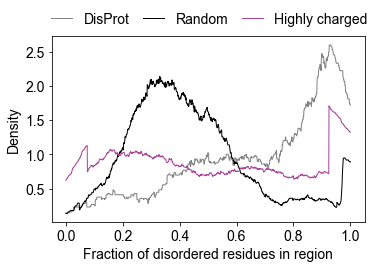

In [18]:
fig, ax = plt.subplots(figsize=(5.5,4.05))

X_plot = np.linspace(0, 1, 1000).reshape(-1, 1)
kde = KernelDensity(kernel="tophat", bandwidth=0.07309).fit(idr_disordered_frac.reshape(-1, 1))
dens = kde.score_samples(X_plot)
ax.plot(X_plot, np.exp(dens), label='DisProt', color=cscheme['dis'], linewidth=1)

kde = KernelDensity(kernel="tophat", bandwidth=0.04767).fit(rand_disordered_frac.reshape(-1, 1))
dens = kde.score_samples(X_plot)
ax.plot(X_plot, np.exp(dens), label='Random', color=cscheme['null'], linewidth=1)

kde = KernelDensity(kernel="tophat", bandwidth=0.07546).fit(hits_disordered_frac.reshape(-1, 1))
dens = kde.score_samples(X_plot)
ax.plot(X_plot, np.exp(dens), label='Highly charged', color=cscheme['cr'], linewidth=1)

plt.xlabel('Fraction of disordered residues in region')
plt.ylabel('Density')
plt.legend(bbox_to_anchor=(1.05, 1.2), ncol=3, columnspacing=1, frameon=False, handlelength=1.5)
plt.tight_layout()
plt.savefig('./plots/Figure2A.png', dpi=300)
plt.show()

## B

In [19]:
data_dict = {"DisProt\nregions":None, "Random\nregions":None, "Highly charged\nregions":None}
labs = ["DisProt\nregions", "Random\nregions", "Highly charged\nregions"]
datums = [idr_ss, rand_ss, hits_ss]
confs = [idr_conf, rand_conf, hits_conf]

for i in range(3):
    out = {"Helix":0, "Sheet":0, "Disordered":0}
    for s, seq in enumerate(datums[i]):
        for aa in seq[confs[i][s]]:
            if aa == "C":
                out["Disordered"]+=1
            elif aa == "H":
                out["Helix"]+=1
            elif aa == "E":
                out["Sheet"]+=1
            else:
                pass
        diso = len(confs[i][s]) - len(seq[confs[i][s]])
        assert diso >= 0
        out["Disordered"] += diso
    data_dict[labs[i]] = out

allssdf = pd.DataFrame(data_dict)
allssdf.reset_index(inplace=True)
allssdf.rename(columns={'index':"ss_type"}, inplace=True)
allssdf = allssdf.melt(id_vars='ss_type', var_name="prot_type", value_name='n_aas')

In [20]:
allssdf = pd.DataFrame(data_dict)
allssdf.reset_index(inplace=True)
allssdf.rename(columns={'index':"ss_type"}, inplace=True)
allssdf = allssdf.melt(id_vars='ss_type', var_name="prot_type", value_name='n_aas')

In [21]:
allssdf

,ss_type,prot_type,n_aas
0,Helix,DisProt\nregions,6457
1,Sheet,DisProt\nregions,1618
2,Disordered,DisProt\nregions,35240
3,Helix,Random\nregions,24261
4,Sheet,Random\nregions,7584
5,Disordered,Random\nregions,32884
6,Helix,Highly charged\nregions,22709
7,Sheet,Highly charged\nregions,1151
8,Disordered,Highly charged\nregions,38910


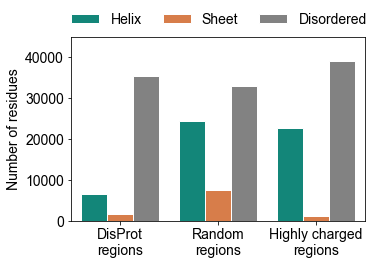

In [22]:
plt.figure(figsize=(5.5,4))
sns.barplot(data=allssdf, x="prot_type", y="n_aas", hue='ss_type',
            palette=[cscheme['helix'], cscheme['sheet'], cscheme['dis']],
            edgecolor="white")
plt.xlabel(None)
plt.ylabel("Number of residues")
plt.legend(title=None, ncol=3, bbox_to_anchor=(1.05, 1.2), frameon=False,
           columnspacing=1.5)
plt.ylim(0,45000)
plt.tight_layout()
plt.savefig('./plots/Figure2B.png', dpi=300)
plt.show()

## D

In [122]:
tops_df = pd.read_csv("../data/top-structured-and-unstructured/2021-11-04_highly-structured_scored.csv")
tops_df = tops_df[tops_df["gene"] != "NPA3"] # I mislabeled this protein because the indexes in PDB were different than SGD

In [123]:
prot_counts = tops_df[["orf","structure.in.pdb"]]
prot_counts.drop_duplicates(inplace=True)
prot_counts = prot_counts['structure.in.pdb'].value_counts()
prot_freqs = prot_counts/np.sum(prot_counts)

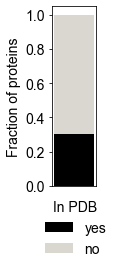

In [130]:
plt.figure(figsize=(0.8,3.3))
plt.bar(" ",prot_freqs["y"], label = "yes", color=cscheme['null'])
plt.bar(" ",prot_freqs["n"], bottom=prot_freqs["y"], label = "no", color="#D9D7CF")
plt.legend(bbox_to_anchor=(1.5, -0.01), title="In PDB", frameon=False)
plt.ylabel("Fraction of proteins")
plt.tick_params(bottom=False)
#plt.tight_layout()
plt.savefig('./plots/Figure2D-left.png', dpi=300, bbox_inches='tight')
plt.show()

In [126]:
y_prots = tops_df[["orf", "left.bound", "structure.in.pdb", "region.in.pdb", "helix"]]
y_prots = y_prots[y_prots["structure.in.pdb"] == 'y']

In [127]:
def make_region_label(row):
    if row["region.in.pdb"] == "n":
        return("Region absent")
    else:
        if row["helix"] == "y":
            return("Resolved helix")
        elif row["helix"] == "partial":
            return("Resolved helix")
        else:
            return("Resolved other")

y_prots["label"] = y_prots.apply(make_region_label, axis=1)
region_label_counts = y_prots["label"].value_counts()
region_label_freqs = region_label_counts / np.sum(region_label_counts)

In [128]:
region_label_freqs

Resolved helix    0.645161
Region absent     0.306452
Resolved other    0.048387
Name: label, dtype: float64

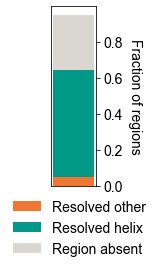

In [134]:
fig, ax = plt.subplots(figsize=(0.8,3.3))
ax.bar(" ",region_label_freqs["Resolved other"], label = "Resolved other", color=cscheme["sheet"])
ax.bar(" ",region_label_freqs["Resolved helix"], bottom=region_label_freqs["Resolved other"],
        label = "Resolved helix", color=cscheme["helix"])
ax.bar(" ",region_label_freqs["Region absent"], bottom=region_label_freqs["Resolved helix"],
        label = "Region absent", color="#D9D7CF")
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
plt.legend(bbox_to_anchor=(2.4, -0.01), frameon=False)
plt.ylabel("Fraction of regions", rotation=270, labelpad=20)
plt.tick_params(bottom=False)
plt.savefig('./plots/Figure2D-right.png', dpi=300, bbox_inches = "tight")
plt.show()

## E

In [24]:
# Calculate normalized hydropathy, net charge, and percent disordered for each sequence
hits_norm_hydrop = []
hits_norm_nc = []
hits_disordered = []

for index, row in df.iterrows():
    orf = row['orf']
    uid = row['uni_id']
    seq = row['region.seq']
    
    # Read alphafold pLDDT scoress for the sequence
    af_fp = paf.get_alphafold_fp(uid, path_to_af_data, version='2')+'.gz'
    try:
        pLDDTs = paf.read_bfactor_from_pdb(af_fp)[row['left.bound']:row['right.bound']]
    except FileNotFoundError:
        print(af_fp)
        continue
    
    # Calculate region hydropathy according to the normalized kyte-doolittle scale
    #hits_norm_hydrop.append(paf.calculate_hydropathy(seq, scale="kd"))
    hits_norm_hydrop.append(comp.calculate_hydropathy(seq, scale="kd_norm"))
    
    # Calculate normalized net charge
    nc = np.abs((seq.count('R') + seq.count('K') - seq.count('E') + seq.count('D'))) / row['region.len']
    hits_norm_nc.append(nc)
    
    # Read secondary structure
    structure = md.load(af_fp)
    ss = md.compute_dssp(structure, simplified=True)[0][row['left.bound']:row['right.bound']]
    
    # Score each residue as disordered or ordered based on pLDDT value
    #disordered = np.sum([1 for i in pLDDTs if i < 70.])
    disordered = 0
    for r, resid in enumerate(pLDDTs):
        if resid < 70.:
            disordered += 1
        elif ss[r] == 'C':
            disordered += 1
        
    # Calculate fraction disorder for the region
    hits_disordered.append(disordered / row['region.len'])

/Users/rosalindpan/hcrpaper_data/UP000002311_559292_YEAST_v2/AF-P53288-F1-model_v2.pdb.gz
/Users/rosalindpan/hcrpaper_data/UP000002311_559292_YEAST_v2/AF-P38811-F1-model_v2.pdb.gz
/Users/rosalindpan/hcrpaper_data/UP000002311_559292_YEAST_v2/AF-P38811-F1-model_v2.pdb.gz
/Users/rosalindpan/hcrpaper_data/UP000002311_559292_YEAST_v2/AF-P36022-F1-model_v2.pdb.gz
/Users/rosalindpan/hcrpaper_data/UP000002311_559292_YEAST_v2/AF-Q12019-F1-model_v2.pdb.gz
/Users/rosalindpan/hcrpaper_data/UP000002311_559292_YEAST_v2/AF-Q12019-F1-model_v2.pdb.gz
/Users/rosalindpan/hcrpaper_data/UP000002311_559292_YEAST_v2/AF-Q12019-F1-model_v2.pdb.gz
/Users/rosalindpan/hcrpaper_data/UP000002311_559292_YEAST_v2/AF-Q12019-F1-model_v2.pdb.gz
/Users/rosalindpan/hcrpaper_data/UP000002311_559292_YEAST_v2/AF-Q6B0X1-F1-model_v2.pdb.gz
/Users/rosalindpan/hcrpaper_data/UP000002311_559292_YEAST_v2/AF-Q08428-F1-model_v2.pdb.gz
/Users/rosalindpan/hcrpaper_data/UP000002311_559292_YEAST_v2/AF-Q12444-F1-model_v2.pdb.gz


In [25]:
df_uversky = pd.DataFrame(columns=['hydrop', 'nc', 'disorder', 'label'])
for i in range(len(hits_disordered)):
    disorder = hits_disordered[i]
    if disorder >= 0.5:
        label = 'Above 0.5'
    if disorder < 0.5:
        label = 'Below 0.5'
    df_uversky = df_uversky.append({'hydrop': hits_norm_hydrop[i], 'nc': hits_norm_nc[i], 'disorder': disorder, 'label': label},
                      ignore_index=True)

In [28]:
cmap = mpl.colors.ListedColormap(["lightgrey", "dimgrey"])
norm = mpl.colors.BoundaryNorm(np.arange(0, 1.1, 0.5), cmap.N) 

In [29]:
colors = {'Above 0.5': 'dimgrey', 'Below 0.5': 'lightgrey'}

In [30]:
from matplotlib.lines import Line2D  

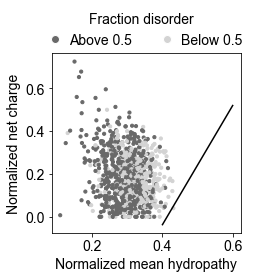

In [31]:
# Values for this diving line from the original paper by Uversky:
# Uversky, V. N., Gillespie, J. R., & Fink, A. L. (2000). Why are “natively unfolded” proteins unstructured under physiologic conditions? Proteins: Structure, Function and Genetics, 41(3), 415–427.
# https://doi.org/10.1002/1097-0134(20001115)41:3<415::AID-PROT130>3.0.CO;2-7
x = np.linspace(0.4,0.6,100)
y = 2.785*x - 1.151

fig,ax = plt.subplots(figsize=(3.4,3.3))
ax.scatter(data=df_uversky, x='hydrop', y='nc', c=df_uversky['label'].map(colors),
            s=10)
ax.plot(x, y, color = 'black')
#cbar = plt.colorbar(sc)
#cbar.set_label('Fraction of disorder')
ax.set_xlabel('Normalized mean hydropathy')
ax.set_ylabel('Normalized net charge')

handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=v, label=k, markersize=8) for k, v in colors.items()]
ax.legend(title='Fraction disorder', handles=handles, columnspacing=1.5, handletextpad=0,
          bbox_to_anchor=(1.07, 1.3), ncol=2, frameon=False)

plt.savefig('./plots/Figure2E.png', dpi=300, bbox_inches = "tight")
plt.show()